Bayesian quadrature - predictions of free-energies in 3D

In [1]:
import emukit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scienceplots
import math
import numpy as np
import skopt
import os
from scipy.interpolate import griddata
import GPy
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy
from emukit.quadrature.kernels import QuadratureRBFLebesgueMeasure
from emukit.quadrature.measures import LebesgueMeasure
from emukit.quadrature.methods import VanillaBayesianQuadrature
plt.style.use(['science','no-latex','grid'])

Below function predicts 1D free-energy profiles for a given protein-plastic system

In [2]:
def integrate_bayesian1D(coms,forces,interval=0.5,plots=False):
    '''
    Integrate the forces to get free energies using Bayesian quadrature. Works for 1 system only.
    Required format: 
    - coms as np arrays (n rows x 1 column)
    - forces as np arrays (n rows x 1 column)
    '''
    lb = coms[0][0]
    integrals = [0]
    ub = np.arange(coms[1][0],coms[-1][0]+interval,interval)
    for upper in ub:
        bounds = [(lb, upper)]
        gpy_model = GPy.models.GPRegression(X=coms, Y=forces, kernel=GPy.kern.RBF(input_dim=1, lengthscale=0.5, variance=1.0))
        emukit_rbf = RBFGPy(gpy_model.kern)
        emukit_measure = LebesgueMeasure.from_bounds(bounds)
        emukit_qrbf = QuadratureRBFLebesgueMeasure(emukit_rbf, emukit_measure)
        emukit_model = BaseGaussianProcessGPy(kern=emukit_qrbf, gpy_model=gpy_model) 
        emukit_method = VanillaBayesianQuadrature(base_gp=emukit_model, X=coms, Y=forces)
        initial_integral_mean, initial_integral_variance = emukit_method.integrate()
        integrals.append(initial_integral_mean)

    if plots:
        fig, ax = plt.subplots(figsize=(8,5))
        ax.plot(coms,integrals)
        ax.set_xlabel(r'COM separation / nm')
        ax.set_ylabel(r'Free-energy / kcal mol$^{-1}$')

    return integrals

def mesh_to_ml(x,y):
    '''
    This function converts between the meshgrid format and the ML-friendly format
    '''
    g = x.flatten()
    h = y.flatten()
    ml_points = np.zeros(shape=(g.size, 2))
    for seq in range(g.size):
        ml_points[seq] = [g[seq], h[seq]]

    return ml_points

Example usage:

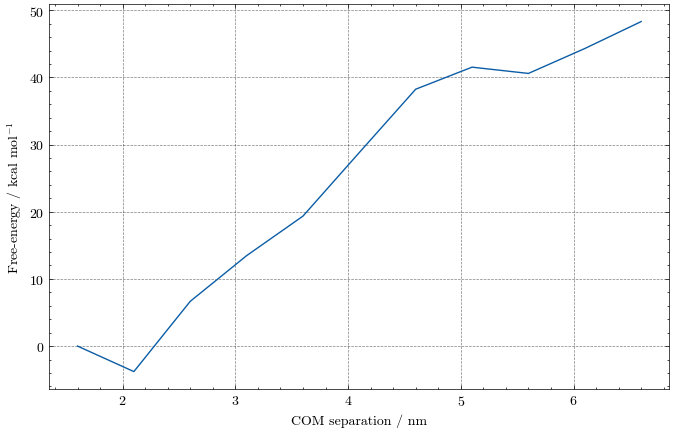

In [3]:
# data for ps0
coms = np.arange(1.6, 7.1, 0.5)[:,None]
forces = np.array([-3.02688208e+01,  1.45797151e+01,  1.91904606e+01,  1.03342495e+01,
        1.48564569e+01,  2.16201295e+01,  1.36285883e+01,  1.27756316e-02,
        3.40677908e-01,  1.25089110e+01,  2.14520711e-01])[:,None]
integrals0 = integrate_bayesian1D(coms,forces, plots=True)

In [4]:
# data for ps10
coms = np.arange(1.6, 7.1, 0.5)[:,None]
forces = np.array([-25.18887238,  16.96057591,  21.57553237,  48.0895323 ,
        -3.73941484,   0.75896396,  -0.35655588,   0.90892453,
         0.22910883,   0.77445991,   0.34886796])[:,None]
integrals10 = integrate_bayesian1D(coms,forces)

In [5]:
# data for ps20
coms = np.arange(1.6, 7.1, 0.5)[:,None]
forces = np.array([-2.98113727e+01,  1.55447903e+01,  1.90716004e+01,  1.16580163e+01,
        6.28428017e+00,  1.10207564e+01, -1.30473691e+00,  2.54545898e+01,
        1.94422368e-03,  3.85487895e-01, -7.63965776e-01])[:,None]
integrals20 = integrate_bayesian1D(coms,forces)

In [6]:
# data for ps40
coms = np.arange(1.6, 7.1, 0.5)[:,None]
forces = np.array([-2.28437063e+01,  1.12823206e+01,  1.81087630e+01,  6.10140899e+00,
        1.35111211e+01,  7.00102434e+00,  1.37923926e+00,  1.06242632e-02,
        2.93544616e+00, -1.86123066e-01,  1.86748396e+00])[:,None]
integrals40 = integrate_bayesian1D(coms,forces)

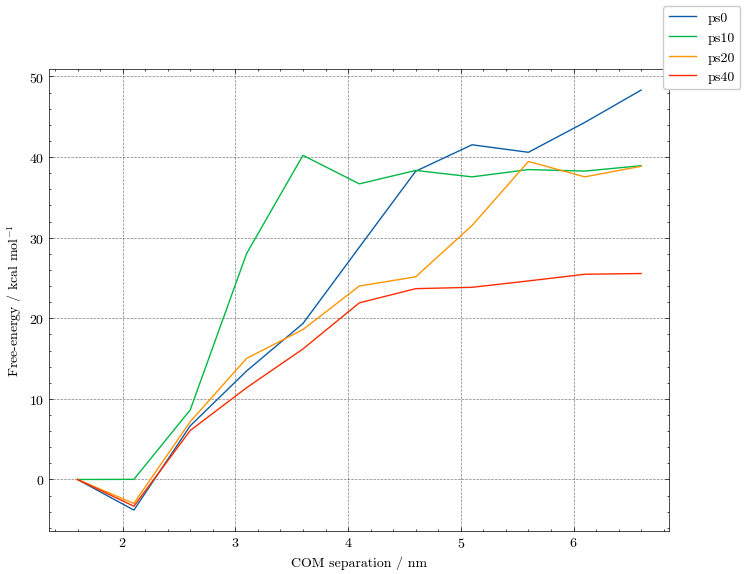

In [7]:
# combined predicted free-energy curves, similar to the umbrella integration output (see: integration.ipynb)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(coms,integrals0, label='ps0')
ax.plot(coms,integrals10, label='ps10')
ax.plot(coms,integrals20, label='ps20')
ax.plot(coms,integrals40, label='ps40')
ax.set_xlabel(r'COM separation / nm')
ax.set_ylabel(r'Free-energy / kcal mol$^{-1}$')
fig.legend()

Going to the full optimiser data

In [8]:
optimizer = skopt.utils.load('/home/fkopczynski/results/gp/optstate_31')
Xs = optimizer.Xi
ys = optimizer.yi

for i, x in enumerate(Xs):
    print(i, '\t', x[0], '\t', x[1], '\t', ys[i])

0 	 0 	 2.1 	 14.579715052631622
1 	 0 	 2.6 	 19.190460644736888
2 	 0 	 3.1 	 10.33424946052636
3 	 0 	 3.6 	 14.856456881578996
4 	 0 	 4.1 	 21.62012953947351
5 	 0 	 4.6 	 13.628588289473507
6 	 0 	 5.1 	 0.012775631578769259
7 	 0 	 5.6 	 0.3406779078945591
8 	 10 	 2.1 	 16.960575907894782
9 	 10 	 2.6 	 21.57553236842109
10 	 10 	 3.1 	 48.089532302631625
11 	 10 	 3.6 	 -3.7394148421052193
12 	 10 	 4.1 	 0.7589639605261377
13 	 10 	 4.6 	 -0.356555881579125
14 	 10 	 5.1 	 0.9089245263156126
15 	 10 	 5.6 	 0.22910882894719065
16 	 20 	 2.1 	 15.544790342105308
17 	 20 	 2.6 	 19.071600368421098
18 	 20 	 3.1 	 11.658016315789519
19 	 20 	 3.6 	 6.284280171052677
20 	 20 	 4.1 	 11.020756381578769
21 	 20 	 4.6 	 -1.3047369078949158
22 	 20 	 5.1 	 25.45458977631561
23 	 20 	 5.6 	 0.0019442236840332768
24 	 40 	 2.1 	 11.282320578947411
25 	 40 	 2.6 	 18.108763013157937
26 	 40 	 3.1 	 6.10140898684215
27 	 40 	 3.6 	 13.511121144736885
28 	 40 	 4.1 	 7.001024342105086
29 

In [9]:
values_to_check = Xs.copy()
results_to_check = ys.copy()

# remove outliers
ndx_to_delete = [59, 45, 36, 31]

for el in ndx_to_delete:
    print(el, '\t', values_to_check[el], '\t', results_to_check[el])
    values_to_check.pop(el)
    results_to_check.pop(el)

# construct arrays to be given to Bayesian quadrature
checked_points_opt = np.array(values_to_check)
checked_data_opt = np.array(results_to_check)[:,None]

59 	 [8, 2.6543395462325776] 	 7.087234071428528
45 	 [17, 3.28] 	 -6.2208695357143835
36 	 [9, 5.252079925152385] 	 18.43866832142857
31 	 [40, 5.6] 	 2.9354461578945594


In [10]:
# print out all the datapoints given to Bayesian quadrature
for x,i in enumerate(range(len(checked_data_opt))):
    print(x, '\t', checked_points_opt[i,0],'\t',checked_points_opt[i,1],'\t',checked_data_opt[i])

0 	 0.0 	 2.1 	 [14.57971505]
1 	 0.0 	 2.6 	 [19.19046064]
2 	 0.0 	 3.1 	 [10.33424946]
3 	 0.0 	 3.6 	 [14.85645688]
4 	 0.0 	 4.1 	 [21.62012954]
5 	 0.0 	 4.6 	 [13.62858829]
6 	 0.0 	 5.1 	 [0.01277563]
7 	 0.0 	 5.6 	 [0.34067791]
8 	 10.0 	 2.1 	 [16.96057591]
9 	 10.0 	 2.6 	 [21.57553237]
10 	 10.0 	 3.1 	 [48.0895323]
11 	 10.0 	 3.6 	 [-3.73941484]
12 	 10.0 	 4.1 	 [0.75896396]
13 	 10.0 	 4.6 	 [-0.35655588]
14 	 10.0 	 5.1 	 [0.90892453]
15 	 10.0 	 5.6 	 [0.22910883]
16 	 20.0 	 2.1 	 [15.54479034]
17 	 20.0 	 2.6 	 [19.07160037]
18 	 20.0 	 3.1 	 [11.65801632]
19 	 20.0 	 3.6 	 [6.28428017]
20 	 20.0 	 4.1 	 [11.02075638]
21 	 20.0 	 4.6 	 [-1.30473691]
22 	 20.0 	 5.1 	 [25.45458978]
23 	 20.0 	 5.6 	 [0.00194422]
24 	 40.0 	 2.1 	 [11.28232058]
25 	 40.0 	 2.6 	 [18.10876301]
26 	 40.0 	 3.1 	 [6.10140899]
27 	 40.0 	 3.6 	 [13.51112114]
28 	 40.0 	 4.1 	 [7.00102434]
29 	 40.0 	 4.6 	 [1.37923926]
30 	 40.0 	 5.1 	 [0.01062426]
31 	 16.0 	 2.98760517884172 	 [38.166

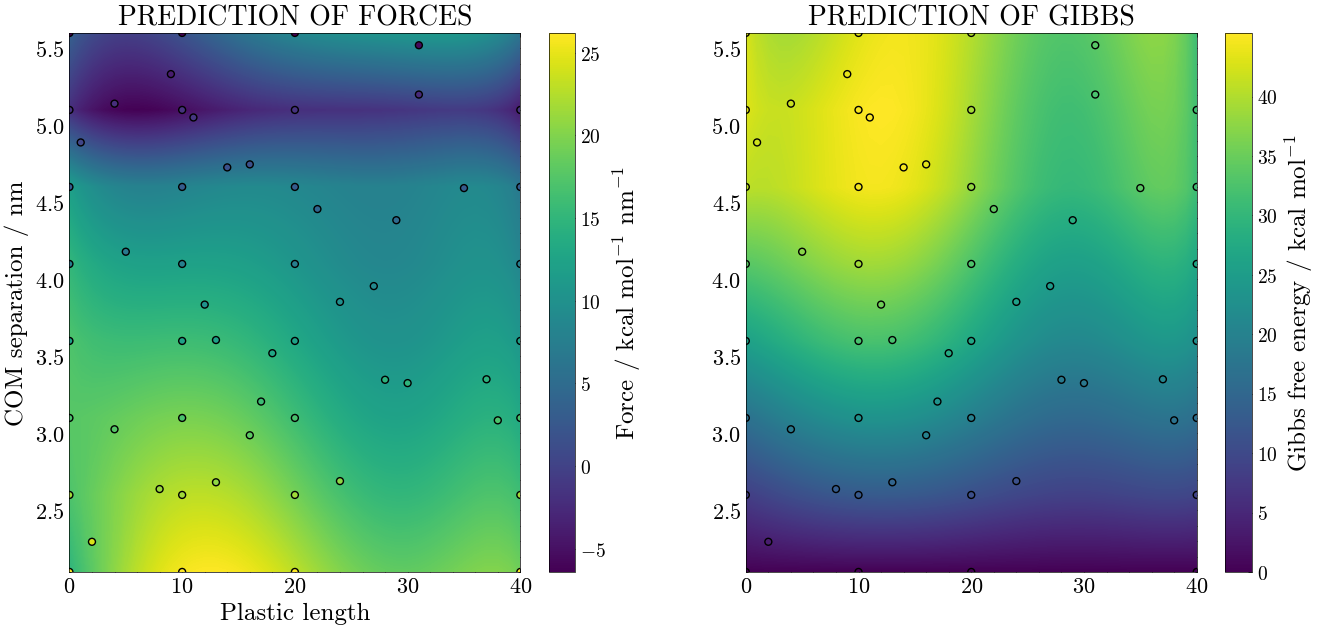

In [13]:
# object needed for defining a non-standard mean function
class CustomMeanFunction(GPy.core.Mapping):
    def __init__(self, input_dim, output_dim, values):
        super(CustomMeanFunction, self).__init__(input_dim=input_dim, output_dim=output_dim)
        self.values = values

    def f(self, X):
        # mean function, determined in get_force.ipynb
        y = np.zeros((X.shape[0], 1))
        for n, x in enumerate(X):
            el_i = float(x[1])
            if el_i < 5:
                y[n] = -6* (el_i-3.5)**2 + 25
            else:
                y[n] = 0
        return y

    def update_gradients(self, params, X):
        # This method is required by GPy but can be left empty if you don't need to optimize the mean function
        pass

    def gradients_X(self, dL_dF, X):
        # This method is also required by GPy but can be left empty if you don't need to compute gradients with respect to X
        return np.zeros(X.shape)

# define your custom values for the mean function
values = np.arange(2.1, 6.1, 0.5)  # Assuming your grid is 0-40 for plastic length and 2.1-5.6 for COM separation

# create the custom mean function
simple_slope = CustomMeanFunction(input_dim=2, output_dim=1, values=values)

# define the dimension limits
bound_len = [0,40]
bound_com = [2.1,5.6]

# construct the model
gpy_model = GPy.models.GPRegression(X=checked_points_opt, Y=checked_data_opt, kernel=GPy.kern.RBF(input_dim=2, lengthscale=50, variance=1.0), mean_function=simple_slope)
emukit_rbf = RBFGPy(gpy_model.kern)
emukit_measure = LebesgueMeasure.from_bounds((bound_len, bound_com))
emukit_qrbf = QuadratureRBFLebesgueMeasure(emukit_rbf, emukit_measure)
emukit_model = BaseGaussianProcessGPy(kern=emukit_qrbf, gpy_model=gpy_model)
emukit_method = VanillaBayesianQuadrature(base_gp=emukit_model, X=checked_points_opt, Y=checked_data_opt)

# generate data for force prediction
lendata = np.arange(0,41)
comdata = np.arange(2.1, 6.1, 0.5)

comgrid, lengrid = np.meshgrid(comdata, lendata)
ml_points = mesh_to_ml(lengrid,comgrid)
mu, var = emukit_model.predict(ml_points)
forces = mu.copy()
forces.resize(comgrid.shape)
gibbs = np.zeros(lengrid.shape)

for length in range(41):
    integral = integrate_bayesian1D(coms=comgrid[length][:,None], forces=forces[length][:,None], plots=False)
    gibbs[length] = integral

plt.style.use(['science','no-latex','grid'])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
ax = axs.flatten()
a = ax[0].contourf(lengrid, comgrid, forces, levels=1000)
ax[0].scatter(checked_points_opt[:,0], checked_points_opt[:,1], s=25, c=checked_points_opt[:,1], cmap=cm.viridis_r, edgecolors='black')
ax[0].set_xlabel('Plastic length', fontsize=18)
ax[0].set_ylabel('COM separation / nm', fontsize=18)
ax[0].set_xlim([bound_len[0], bound_len[1]])
ax[0].set_ylim([bound_com[0], bound_com[1]])
ax[0].set_title('PREDICTION OF FORCES', fontsize=20)
cbarf = fig.colorbar(a, ticks=np.arange(-5,31,5))
cbarf.ax.tick_params(labelsize=14)
cbarf.set_label(r'Force / kcal mol$^{-1}$ nm$^{-1}$', fontsize=18)

x_sample = checked_points_opt[:,0]
y_sample = checked_points_opt[:,1]

z_sample = griddata((lengrid.flatten(), comgrid.flatten()), gibbs.flatten(), (x_sample, y_sample), method='cubic')

b = ax[1].contourf(lengrid, comgrid, gibbs, levels=1000)
ax[1].scatter(checked_points_opt[:,0], checked_points_opt[:,1], s=25, c=z_sample, cmap=cm.viridis, edgecolors='black')
#ax[1].set_xlabel('Plastic length', fontsize=18)
#ax[1].set_ylabel('COM separation / nm', fontsize=18)
ax[1].set_xlim([bound_len[0], bound_len[1]])
ax[1].set_ylim([bound_com[0], bound_com[1]])
ax[1].set_title('PREDICTION OF GIBBS', fontsize=20)
cbarg = fig.colorbar(b,ticks=np.arange(0,45,5))
cbarg.ax.tick_params(labelsize=14)
cbarg.set_label(r'Gibbs free energy / kcal mol$^{-1}$', fontsize=18)

for a in ax:
    a.tick_params(labelsize=16)
#plt.savefig('ALLPOINTS-ps17-ps9_31_8_low-ps4-ps38-ps16-ps17_2-ps35-lowout.png')

In [16]:
# define the umbrella integration-defined values of the free-energy
gib0 = np.array([ 0.        ,  8.44254392, 15.82372145, 22.12139804, 31.24054464,
       40.0527241 , 43.46306508, 43.55142846])
gib10 = np.array([ 0.        ,  9.63402707, 27.05029324, 38.1378226 , 37.39270988,
       37.4933119 , 37.63140406, 37.9159124 ])
gib20 = np.array([ 0.        ,  8.65409768, 16.33650185, 20.82207597, 25.14833511,
       27.57733998, 33.61480319, 39.97893669])
gib40 = np.array([ 0.        ,  7.3477709 , 13.4003139 , 18.30344643, 23.4314828 ,
       25.5265487 , 25.87401459, 26.61053219])

# put UI values in a common array
gib_gen = np.zeros(shape=(4,len(gib0)))
gib_gen[0] = gib0
gib_gen[1] = gib10
gib_gen[2] = gib20
gib_gen[3] = gib40

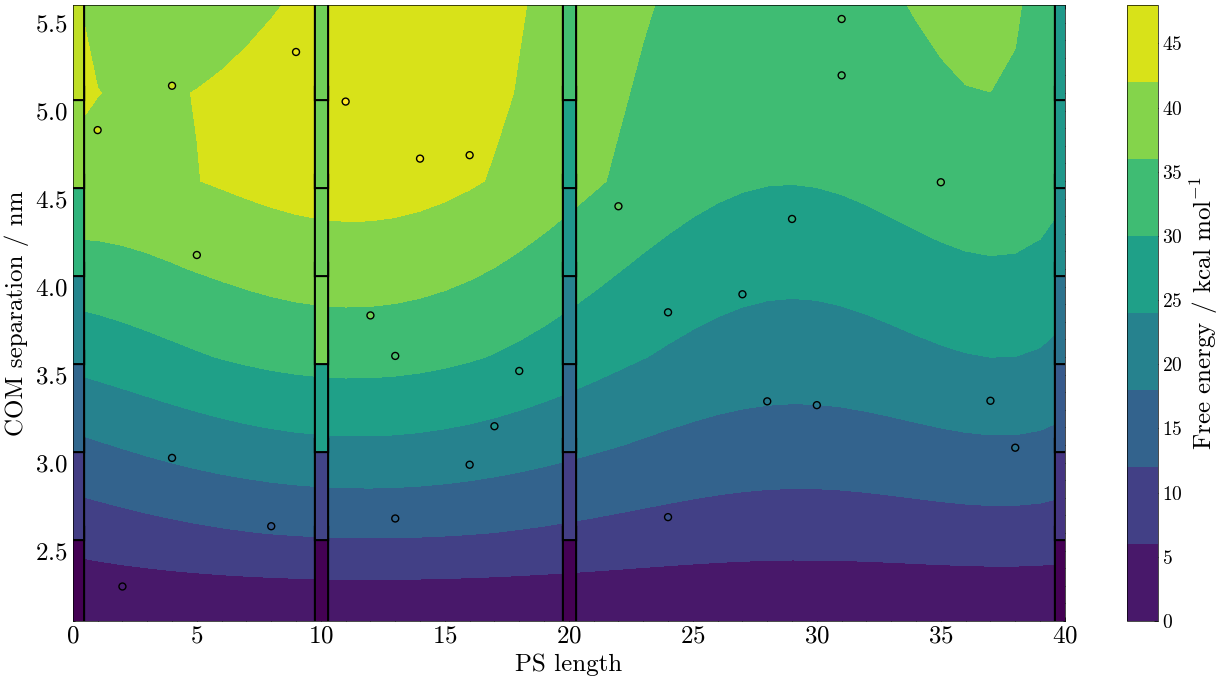

In [17]:
# the final contour plot
fig, ax = plt.subplots(figsize=(16, 8))

x_sample = checked_points_opt[:, 0]
y_sample = checked_points_opt[:, 1]
z_sample = griddata((lengrid.flatten(), comgrid.flatten()), gibbs.flatten(), (x_sample, y_sample), method='cubic')

b = ax.contourf(lengrid, comgrid, gibbs, levels=8)
ax.scatter(checked_points_opt[:, 0], checked_points_opt[:, 1], s=25, c=z_sample, cmap=cm.viridis, edgecolors='black')
ax.set_xlabel('PS length', fontsize=18)
ax.set_ylabel('COM separation / nm', fontsize=18)
ax.set_xlim([bound_len[0], bound_len[1]])
ax.set_ylim([bound_com[0], bound_com[1]])
ax.tick_params(labelsize=18)
cbarg = fig.colorbar(b, ticks=np.arange(0, 50, 5))
cbarg.ax.tick_params(labelsize=14)
cbarg.set_label(r'Free energy / kcal mol$^{-1}$', fontsize=18)

col_map = b.cmap
norm = b.norm

for n, checked_len in enumerate([0.15, 10, 20, 39.85]):
    x = checked_len * np.ones(comgrid.shape[1])
    y = np.arange(2.1, 6.1, 0.5)
    z = gib_gen[n]

    # Plot each segment with its corresponding color
    for i in range(len(y) - 1):
        ax.plot([x[i], x[i+1]], [y[i], y[i+1]], color='black', linewidth=11)
        ax.plot([x[i], x[i+1]], [y[i], y[i+1]], linewidth=8, color=col_map(norm(z[i])), )

#plt.savefig('/home/fkopczynski/fullfreee.png')

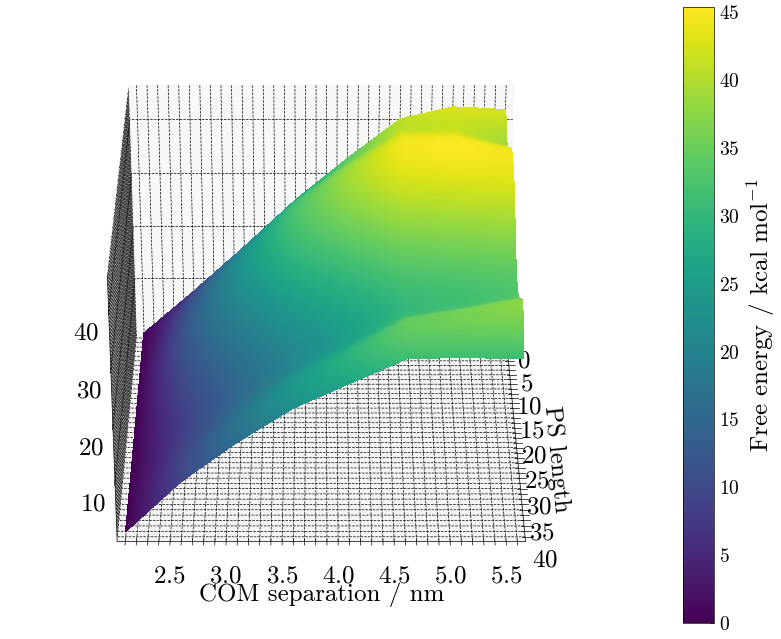

In [18]:
# 3D plot animation
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

x_sample = checked_points_opt[:, 0]
y_sample = checked_points_opt[:, 1]

z_sample = griddata((lengrid.flatten(), comgrid.flatten()), gibbs.flatten(), (x_sample, y_sample), method='cubic')

b = ax.contourf(lengrid, comgrid, gibbs, levels=1000)
#ax.scatter(checked_points_opt2[:, 0], checked_points_opt2[:, 1], s=25, c=z_sample, cmap=cm.viridis, edgecolors='black')
ax.set_xlabel('PS length', fontsize=18)
ax.set_ylabel('COM separation / nm', fontsize=18)
ax.set_xlim([bound_len[0], bound_len[1]])
ax.set_ylim([bound_com[0], bound_com[1]])
ax.tick_params(labelsize=18)
cbarg = fig.colorbar(b, ticks=np.arange(0, 50, 5))
cbarg.ax.tick_params(labelsize=14)
cbarg.set_label(r'Free energy / kcal mol$^{-1}$', fontsize=18)

def update(frame):
    ax.view_init(elev=30, azim=frame)
    return fig,

ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=50, blit=True)

#ani.save('/home/fkopczynski/3d_contour_animation.gif', writer='pillow')

Hyperparameter (lengthscale) optimisation

In [20]:
# average differences between Bayesian quadrature predictions and umbrella integration
print("Average difference \t Sigma")
print(np.average(gibbs-gib0), "\t", np.std(gibbs-gib0))
print(np.average(gibbs-gib10), "\t", np.std(gibbs-gib10))
print(np.average(gibbs-gib20), "\t", np.std(gibbs-gib20))
print(np.average(gibbs-gib40), "\t", np.std(gibbs-gib40))

Average difference 	 Sigma
-0.2831614719703695 	 4.984098046588218
-2.8531684044703702 	 5.956410460232323
3.78725543052963 	 5.1529138856881245
7.742003050529631 	 5.7341953074952325


In [21]:
# initialise the average and standard deviation lists
gib0av = np.zeros(40)
gib0std = np.zeros(40)
gib10av= np.zeros(40)
gib10std= np.zeros(40)
gib20av= np.zeros(40)
gib20std= np.zeros(40)
gib40av= np.zeros(40)
gib40std= np.zeros(40)

# define lengthscale values to test
test_vals = np.arange(1,200,5)

# test different models, save their predictions for 0, 10, 20 and 40 in the arrays above (will take a moment)
for n,x in enumerate(test_vals):
    # Define the GP model with the custom mean function
    gpy_model = GPy.models.GPRegression(X=checked_points_opt, Y=checked_data_opt, kernel=GPy.kern.RBF(input_dim=2, lengthscale=x, variance=1.0), mean_function=simple_slope)
    emukit_rbf = RBFGPy(gpy_model.kern)
    emukit_measure = LebesgueMeasure.from_bounds((bound_len, bound_com))
    emukit_qrbf = QuadratureRBFLebesgueMeasure(emukit_rbf, emukit_measure)
    emukit_model = BaseGaussianProcessGPy(kern=emukit_qrbf, gpy_model=gpy_model)
    emukit_method = VanillaBayesianQuadrature(base_gp=emukit_model, X=checked_points_opt, Y=checked_data_opt)
    
    # generate data for force prediction
    lendata = np.arange(0,41)
    comdata = np.arange(2.1, 6.1, 0.5)
    
    comgrid, lengrid = np.meshgrid(comdata, lendata)
    ml_points = mesh_to_ml(lengrid,comgrid)
    mu, var = emukit_model.predict(ml_points)
    forces = mu.copy()
    forces.resize(comgrid.shape)
    gibbs = np.zeros(lengrid.shape)
    
    for length in range(41):
        integral = integrate_bayesian1D(coms=comgrid[length][:,None], forces=forces[length][:,None], plots=False)
        gibbs[length] = integral

    # save the average differences and the standard deviations
    gib0av[n] = np.average(gibbs[0] - gib0)
    gib0std[n] = np.std(gibbs[0] - gib0)
    gib10av[n] = np.average(gibbs[10] - gib10)
    gib10std[n] = np.std(gibbs[10] - gib10)
    gib20av[n] = np.average(gibbs[20] - gib20)
    gib20std[n] = np.average(gibbs[20] - gib20)
    gib40av[n] = np.average(gibbs[40] - gib40)
    gib40std[n] = np.std(gibbs[40] - gib40)


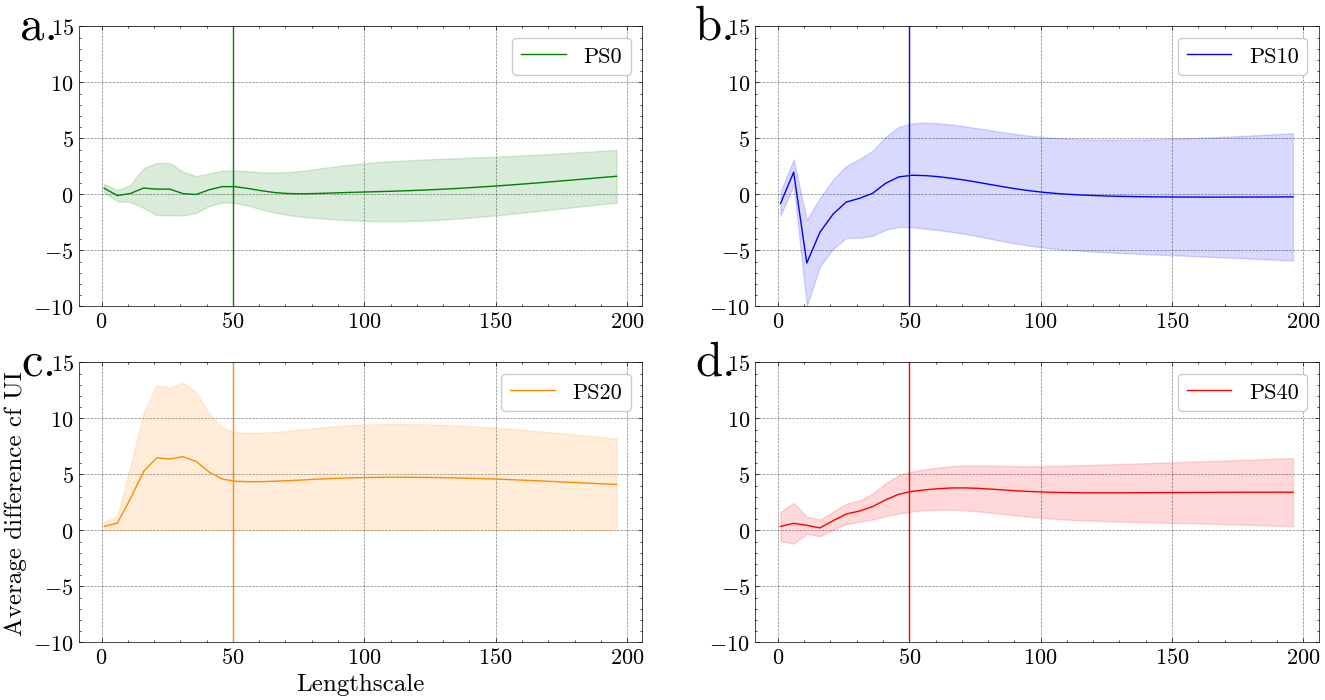

In [22]:
# plot the average differences
pl, axs = plt.subplots(2,2,figsize=(16,8))
ax = axs.flatten()
ax[0].plot(test_vals, gib0av, label='PS0', color='green')
ax[0].fill_between(test_vals, gib0av-gib0std, gib0av+gib0std, color='green', alpha=0.15)
ax[1].plot(test_vals, gib10av, label='PS10', color='blue')
ax[1].fill_between(test_vals, gib10av-gib10std, gib10av+gib10std, color='blue', alpha=0.15)
ax[2].plot(test_vals, gib20av, label='PS20', color='darkorange')
ax[2].fill_between(test_vals, gib20av-gib20std, gib20av+gib20std, color='darkorange', alpha=0.15)
ax[3].plot(test_vals, gib40av, label='PS40', color='red')
ax[3].fill_between(test_vals, gib40av-gib40std, gib40av+gib40std, color='red', alpha=0.15)
ax[2].set_xlabel('Lengthscale', fontsize=18)
ax[2].set_ylabel('Average difference cf UI', fontsize=18)

# set a vertical line at 50, the final chosen value
ax[0].axvline(50, color='green')
ax[1].axvline(50, color='blue')
ax[2].axvline(50, color='darkorange')
ax[3].axvline(50, color='red')

labels = ['a.', 'b.', 'c.', 'd.']
for i, label in enumerate(labels):
    ax[i].annotate(label, xy=(-0.07, 1.00), xycoords='axes fraction', fontsize=35, fontweight='bold', ha='center', va='center')
    ax[i].set_ylim(-10,15)
    ax[i].legend(fontsize=16)
    ax[i].tick_params(labelsize=16)


#plt.savefig('/home/fkopczynski/hyperparam_opt.pdf')